<a href="https://colab.research.google.com/github/yasseriz/SRGAN/blob/yasseriz-final/Autoencoder_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Cloned SRGAN repo
!git clone https://github.com/yasseriz/SRGAN.git

Cloning into 'SRGAN'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 64 (delta 4), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (64/64), done.


In [0]:
cd SRGAN/

/content/SRGAN


In [0]:
!git checkout yasseriz-final

Branch 'yasseriz-final' set up to track remote branch 'yasseriz-final' from 'origin'.
Switched to a new branch 'yasseriz-final'


In [0]:
# !cd ..
%ls


baboon.png   coastguard.png  flowers.png  man.png      ppt3.png      zebra.png
barbara.png  comic.png       foreman.png  monarch.png  sample_data/
bridge.png   face.png        lenna.png    pepper.png   SRGAN/


In [1]:
!pip install scipy==1.0.0

     |████████████████████████████████| 50.0MB 78kB/s 
ERROR: tensorflow 2.2.0rc2 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.0.0 which is incompatible.
ERROR: seaborn 0.10.0 has requirement scipy>=1.0.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: cvxpy 1.0.29 has requirement scipy>=1.1.0, but you'll have scipy 1.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
%tensorflow_version 1.x

In [0]:
import keras
import numpy as np
from scipy.misc import imresize, imread
from keras import Input
from keras.layers import BatchNormalization, Activation, Add, LeakyReLU, Dense, MaxPooling2D
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.applications import VGG19
import matplotlib.pyplot as plt
from glob import glob
import scipy.misc
from PIL import Image
import tensorflow as tf


In [0]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):

    # Make a list of all images inside the data directory
    all_images = data_dir

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)

        # Do a random horizontal flip
        if np.random.random() < 0.5:
          img1_high_resolution = np.fliplr(img1_high_resolution)
          img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)

In [0]:
def save_images(low_resolution_images, high_resolution_images, generated_images, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_images[0])
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(high_resolution_images[0])
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_images[0])
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)
    plt.clf()

In [0]:
# AutoEncoder Block
def build_autoencoder():

    input_shape = (256, 256, 3)
    input_layer = Input(shape=input_shape)


    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', strides=1, padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(256, (3, 3), activation='relu', strides=1, padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', strides=1, padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='tanh', strides=1, padding='same')(x)

    autoencoder = Model(input_layer, decoded)
    return autoencoder
    autoencoder.compile(optimizer='adadelta', loss='mse')

In [0]:
# Using a pretrained network
def build_vgg():
    """
    Builds a pre-trained VGG19 model that outputs image features extracted at the
    third block of the model
    """
    input_shape = (64, 64, 3)
    vgg = VGG19(weights="imagenet", input_shape=input_shape, include_top=False)
    # Set the outputs to outputs of last conv. layer in block 3
    # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
    newOutput = vgg.predict(low_resolution_images)
    print(vgg.summary())
    img = Input(shape=input_shape)

    # Extract the image features
    img_features = vgg(img)

    return Model(inputs=[img], outputs=[img_features], name='VGG')

In [0]:
data_dir = glob('./Dataset/*')
epochs = 51
batch_size = 1
low_resolution_shape=(64, 64, 3)
high_resolution_shape=(256, 256, 3)


In [13]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='Adam', loss='mse')
# print(autoencoder.metric_names)
print(autoencoder.summary())


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 512)     14336     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 512)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 256)     1179904   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       590080    
___________________________________________

In [0]:
vgg = build_vgg()
vgg.trainable = False
vgg.compile(optimizer='Adam', metrics=['accuracy'], loss='mse')
print(vgg.summary())

In [0]:
# Adding black pixels to image to simulate generated image from generator
newpath = 'NoisyData/'
datapoints = 16384
for j in range(50):
    high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                            high_resolution_shape=high_resolution_shape,
                                                                            low_resolution_shape=low_resolution_shape)
    # high_resolution_images = high_resolution_images / 127.5 - 1
    for i in range(datapoints):
        xpoints = np.random.randint(0, 256)
        ypoints = np.random.randint(0, 256)
        zpoints = np.random.randint(0, 3)
        high_resolution_images[0][xpoints][ypoints][0] = 0
        high_resolution_images[0][xpoints][ypoints][1] = 0
        high_resolution_images[0][xpoints][ypoints][2] = 0
    new_noisy_high_resolution_images = high_resolution_images
    print(new_noisy_high_resolution_images.shape)
    # fig = plt.figure()
    # plt.imshow(high_resolution_images[0])
    # plt.savefig(newpath+str(j))
    # plt.clf()
    scipy.misc.imsave(newpath+str(j)+'.png', new_noisy_high_resolution_images[0])
    # im = Image.fromarray(new_noisy_high_resolution_images[0])
    # im.save(newpath+str(j)+'.png')

In [0]:
!zip -r /content/file.zip /content/NoisyData 
from google.colab import files
files.download("/content/file.zip") 

In [0]:
 # create tensorboard graph data for the model
# tb = tf.keras.callbacks.TensorBoard(log_dir='Logs/Exp_15', 
#                                     histogram_freq=0, 
#                                     batch_size=batch_size, 
#                                     write_graph=True, 
#                                     write_grads=False)

# tb.set_model(autoencoder)
# %load_ext tensorboard
# %tensorboard --logdir './Logs'
dataLoss = []

for epoch in range(epochs):
    high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                            high_resolution_shape=high_resolution_shape,
                                                                            low_resolution_shape=low_resolution_shape)
    noisy_high_resolution_images = high_resolution_images
    datapoints = 16384
    for i in range(datapoints):
        xpoints = np.random.randint(0, 256)
        ypoints = np.random.randint(0, 256)
        zpoints = np.random.randint(0, 3)
        noisy_high_resolution_images[0][xpoints][ypoints][0] = 0
        noisy_high_resolution_images[0][xpoints][ypoints][1] = 0
        noisy_high_resolution_images[0][xpoints][ypoints][2] = 0

    high_resolution_images = high_resolution_images / 127.5 - 1
    low_resolution_images = low_resolution_images / 127.5 - 1
    noisy_high_resolution_images = noisy_high_resolution_images / 127.5 - 1

    # noise_factor = 0.2
    # noisy_low_resolution_images = high_resolution_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=high_resolution_shape) 
    # noisy_low_resolution_images = np.clip(noisy_low_resolution_images, 0., 1.)
    
    loss = autoencoder.train_on_batch(noisy_high_resolution_images, high_resolution_images)
    print("Epoch:"+str(epoch)+" Loss:"+str(loss))
    # tb.on_epoch_end(epoch, {'train_loss': loss})
    
    if epoch%10==0:
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              high_resolution_shape=high_resolution_shape,
                                                                              low_resolution_shape=low_resolution_shape)
        noisy_high_resolution_images = high_resolution_images
        datapoints = 16384
        for i in range(datapoints):
            xpoints = np.random.randint(0, 256)
            ypoints = np.random.randint(0, 256)
            zpoints = np.random.randint(0, 3)
            noisy_high_resolution_images[0][xpoints][ypoints][0] = 0
            noisy_high_resolution_images[0][xpoints][ypoints][1] = 0
            noisy_high_resolution_images[0][xpoints][ypoints][2] = 0

        noisy_high_resolution_images = noisy_high_resolution_images / 127.5 - 1
        # Normalizing the images
        high_resolution_images = high_resolution_images / 127.5 - 1
        low_resolution_images = low_resolution_images / 127.5 - 1
        # noisy_low_resolution_images = high_resolution_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=high_resolution_shape) 
        # noisy_low_resolution_images = np.clip(noisy_low_resolution_images, 0., 1.)
        generated_images = autoencoder.predict_on_batch(noisy_high_resolution_images)

        high_resolution_images = 0.5 * high_resolution_images + 0.5
        low_resolution_images = 0.5 * low_resolution_images + 0.5
        generated_images = 0.5 * generated_images + 0.5
        print(generated_images.shape)
        for index, img in enumerate(generated_images):
            save_images(noisy_high_resolution_images, high_resolution_images, generated_images,
                        path="Results/img_{}".format(epoch))
# tb.on_train_end(None)


In [0]:
def visualize_conv_layer(layer_name):
  high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              high_resolution_shape=high_resolution_shape,
                                                                              low_resolution_shape=low_resolution_shape)
  high_resolution_images = high_resolution_images / 127.5 - 1
  low_resolution_images = low_resolution_images / 127.5 - 1

  layer_output=generator.get_layer(layer_name).output
#   layer_output=autoencoder.get_layer(layer_name).output

#   intermediate_model=Model(inputs=autoencoder.input,outputs=layer_output)
  intermediate_model=Model(inputs=generator.input,outputs=layer_output)

#   intermediate_prediction=intermediate_model.predict(high_resolution_images[0].reshape(1,256,256,3))
#   high_resolution_images = 0.5 * high_resolution_images + 0.5
  intermediate_prediction=intermediate_model.predict(low_resolution_images[0].reshape(1,64,64,3))
  low_resolution_images = 0.5 * low_resolution_images + 0.5

  row_size=4
  col_size=8
  
  img_index=0

  print(np.shape(intermediate_prediction))
#   plt.figure
#   plt.imshow(intermediate_prediction[0][:][:][0])

  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8))

  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='viridis')

      img_index=img_index+1

In [23]:
autoencoder.input

<tf.Tensor 'input_1:0' shape=(?, 256, 256, 3) dtype=float32>

In [14]:
Model(inputs=autoencoder.input,outputs=autoencoder.get_layer('conv2d_3').output)

In [0]:
visualize_conv_layer('conv2d_3')

In [0]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = PReLU()

    res = Conv2D(filters=filters[0], kernel_size=kernel_size,
                 strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size,
                 strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

In [0]:
# Original generator model
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)
    counter = 0

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(input_layer)
    gen1 = Activation(PReLU())(gen1)
    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and
    #  the post-residual block(gen2)
    gen3 = Add(name='trial')([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    # gen4 = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation(PReLU())(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    # gen5 = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation(PReLU())(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same', activation='tanh')(gen5)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[gen6],
                  name='generator')

    return model

In [20]:
generator = build_generator()
print("generator")
print(generator.summary())

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


generator
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 64)   15616       input_2[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64)   262144      conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 64)   36928       activation_1[0][0]               
________________________________________________________________________________

In [0]:
visualize_conv_layer('conv2d_41')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


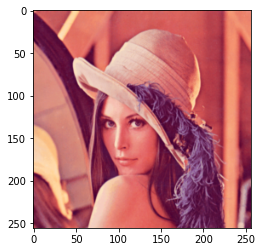

1 256 256 3


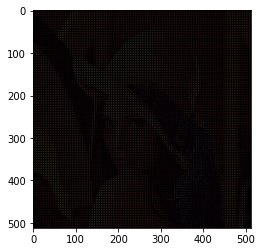

[[0.86666667 0.45490196 0.40392157]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
(1, 512, 512, 3)


In [115]:
high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              high_resolution_shape=high_resolution_shape,
                                                                              low_resolution_shape=low_resolution_shape)
# plt.imshow(high_resolution_images[0])
# plt.show()
high_resolution_images = high_resolution_images / 255
# low_resolution_images = low_resolution_images / 255
plt.imshow(high_resolution_images[0])
plt.show()

temp = np.zeros([1,512,512,3])
a,b,c,d = high_resolution_images.shape
print(a,b,c,d)
for k in range(3):
    for i in range(255):
        for j in range(255):
            
            if i%2==0 and j%2==0:
                temp[0][2*i][2*j][k] = high_resolution_images[0][i][j][k]
            else:
                temp[0][i][j][k] = 0
plt.imshow(temp[0])
plt.show()
plt.save(temp[0])
# print(high_resolution_images[0][0:1][:][0])
print(temp[0][0:1][:][0])
print(temp.shape)

In [0]:
import matplotlib

matplotlib.image.imsave('test/name.png', temp[0])